In [35]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tools import *
import operator
import itertools
np.random.seed(0)
torch.manual_seed(0)
opt= {}
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    opt['device']= torch.device('cuda:0')
    opt['if_cuda']=True
else:
    opt['device']= torch.device('cpu')
    opt['if_cuda']=False

In [36]:
mu=0.0
std=1.0

def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

def entropy(p):
    return -p*np.log(p)-(1-p)*np.log(1-p)
    
# def cdf(x,mu,std):
    #0.5*(1+erf((x-mu)/(np.sqrt(2)*std)))

def app(mu,std):
    return sigmoid(np.sqrt(1+(np.pi*(std**2)/8))*mu)

def all(mu,std):
    return entropy(app(mu,std))

print(all(0.0,1.0))
print(all(0.0,2.0))

0.6931471805599453
0.6931471805599453


In [37]:
def yo_kronecker(t1, t2):
    """
    Computes the Kronecker product between two tensors.
    See https://en.wikipedia.org/wiki/Kronecker_product
    """
    t1_height, t1_width = t1.size()
    t2_height, t2_width = t2.size()
    out_height = t1_height * t2_height
    out_width = t1_width * t2_width

    tiled_t2 = t2.repeat(t1_height, t1_width)
    expanded_t1 = (
        t1.unsqueeze(2)
          .unsqueeze(3)
          .repeat(1, t2_height, t2_width, 1)
          .view(out_height, out_width)
    )

    return expanded_t1 * tiled_t2
# a=torch.diag(torch.ones(2))
# b=torch.tensor([1.0,2.0]).view(1,2)
# print(kronecker(a,b))

In [38]:
train_data=torchvision.datasets.MNIST('./', train=True, download=True,transform=torchvision.transforms.ToTensor())
test_data=torchvision.datasets.MNIST('./', train=False, download=True,transform=torchvision.transforms.ToTensor())
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

In [39]:
train_dict={}
for (data, target) in train_data:
    if  target.item() not in train_dict:
        train_dict[target.item()]=[]
        train_dict[target.item()].append(data)
    else:
        train_dict[target.item()].append(data)

In [40]:
initial_train_data=[]
initial_train_label=[]
for i in range(5):
    for j in range(0,10):
        initial_train_data.append(train_dict[i][j])
        initial_train_label.append(i)
    
print(initial_train_label)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [41]:
initial_train_data_tensor=torch.stack(initial_train_data)
initial_train_label_tensor=torch.tensor(initial_train_label)
train_x=torch.stack([data for (data, target) in train_data])
train_label=torch.tensor([target for (data, target) in train_data])
print(initial_train_data_tensor.size())
print(initial_train_label_tensor.size())

torch.Size([50, 1, 28, 28])
torch.Size([50])


In [53]:
class Net(nn.Module):
    def __init__(self,feature_dim,q_rank):
        super(Net, self).__init__()
        self.feature_dim=feature_dim
        self.last_weight_dim=feature_dim*10
        self.device=opt['device']
        self.if_cuda=opt['if_cuda']
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 100)
        self.fc2 = nn.Linear(100, feature_dim)

        self.q_rank=q_rank
        self.prior_mu=torch.tensor(np.zeros(self.last_weight_dim), dtype=torch.float, requires_grad=False)
        self.prior_sigma=torch.tensor(1.0, requires_grad=False)
        
        self.q_mu=(torch.randn(self.last_weight_dim)*0.1).requires_grad_()
        self.q_sigma=torch.tensor(1.0, requires_grad=True)
        self.q_L=(torch.randn(self.last_weight_dim,q_rank)*0.1).requires_grad_()
        
        
        params = list(self.parameters()) + [self.q_mu,self.q_L,self.q_sigma]
        self.optimizer = optim.Adam(params, lr=0.001)
        self.feature_optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.final_optimizer = optim.Adam([ self.q_mu,self.q_L,self.q_sigma], lr=0.001)
        self.online_optimizer = optim.Adam([ self.q_mu,self.q_L,self.q_sigma], lr=0.001)

    def forward(self, x, final_weight):
        x=x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x =torch.tanh(self.fc2(x))
        x= torch.matmul(x,final_weight)
        return F.log_softmax(x,dim=-1)
    
    
    def feature_forward(self, x ):
        x=x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = torch.tanh( self.fc2(x))
        return x
    
    def predict(self,x):
        with torch.no_grad():
            eps=torch.tensor(np.random.normal([self.last_weight_dim]),dtype=torch.float)
            final_weight_sample= (self.q_mu+eps*torch.sqrt(self.q_diag)).view(self.feature_dim,10)
            output = torch.exp(self.forward(x,final_weight_sample))
            pred = output.data.max(dim=1, keepdim=True)[1]
            return pred
        
    def test_prediction(self, x):
        with torch.no_grad():
            final_weight_mean=self.q_mu.view(self.feature_dim,10)
            output = torch.exp(self.forward(x,final_weight_mean))
            pred = output.data.max(dim=1, keepdim=True)[1]
            return pred
        
        
    def predictive_distribution_entropy_batch(self,x, sample_num=100):
        with torch.no_grad():
            final_weight_samples=low_rank_gaussian_sample(self.q_mu.to(self.device),self.q_L.to(self.device),self.q_sigma.to(self.device),sample_num,cuda=self.if_cuda).view(sample_num,self.feature_dim,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)### 70*20
            output_logit=F.log_softmax((final_weight_samples@feature_of_data.t()).permute(2,0,1),dim=-1) ###70*100*10
            final_weight_samples=low_rank_gaussian_sample(self.q_mu.to(self.device),self.q_L.to(self.device),self.q_sigma.to(self.device),sample_num,cuda=self.if_cuda).view(sample_num,self.feature_dim,10).permute(0, 2, 1)
            output_probs=F.softmax(output_logit,dim=-1) ###70*100*10
            output_dis_for_sample=sample_from_batch_categorical_multiple(output_logit,sample_num=30,cuda=self.if_cuda).view(x.size(0),-1) ### 70*100*30
            output_dis_for_sample_one_hot=one_hot_embedding(output_dis_for_sample, 10, cuda=self.if_cuda) ### 70*3000*10
            output_probs=output_probs@output_dis_for_sample_one_hot.permute(0,2,1) ### 70*100*3000
            entropy_list=-torch.mean(torch.log(torch.mean(output_probs,dim=1)),dim=-1)
            return entropy_list
    
    
    def likelihood_eva(self,x,label, sample_num=100, if_online=False):
        with torch.no_grad():
            eps=torch.randn([sample_num,self.last_weight_dim])
            final_weight_samples=low_rank_gaussian_sample(self.q_mu.to(self.device),self.q_L.to(self.device),self.q_sigma.to(self.device),sample_num).view(sample_num,self.feature_dim,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)
            output=torch.mean(F.log_softmax((final_weight_samples@feature_of_data.t()).permute(0, 2, 1),dim=-1),0)
            predicted=output.data.max(dim=1, keepdim=True)[1].view(-1)
            accuracy=(predicted == label).sum().item()/label.size(0)
            nll_loss= F.nll_loss(output,label)
            if if_online:
                curr_prior_mu = self.q_mu.clone().detach()
                curr_prior_L = self.q_L.clone().detach()
                curr_prior_sigma = self.q_sigma.clone().detach()
                kl=KL_low_rank_gaussian_with_low_rank_gaussian(self.q_mu.to(self.device),self.q_L.to(self.device),self.q_sigma.to(self.device),curr_prior_mu,curr_prior_L,curr_prior_sigma)
            else:
                kl=KL_low_rank_gaussian_with_diag_gaussian(self.q_mu.to(self.device),self.q_L.to(self.device),self.q_sigma.to(self.device),self.prior_mu.to(self.device),self.prior_sigma.to(self.device))
            neg_elbo=kl+nll_loss
        
        return -neg_elbo,accuracy
    
    def preactivation_entropy(self,x):
        with torch.no_grad():
            feature_of_data=self.feature_forward(x)
            diag=torch.diag(torch.ones(10)).to(self.device)
            left=yo_kronecker(diag,feature_of_data.view(1,self.feature_dim))
            cov=self.q_L.to(self.device)@self.q_L.to(self.device).t()+torch.diag(torch.ones(self.last_weight_dim).to(self.device))*self.q_sigma.to(self.device)
            transformed_cov=left@cov@(left.t())
            mean=feature_of_data@self.q_mu.view(self.feature_dim,10).view(-1)
            
            print(mean.size())
            m=torch.cholesky(transformed_cov)
            randn=torch.randn([100,10]).cuda()
            
            logit_samples=(mean+randn@m)
            print(logits_samples.size())
            output_dis_for_sample=torch.distributions.categorical.Categorical(logits=logit_samples)
            sample=output_dis_for_sample.sample([sample_num]).reshape([-1,1])
            entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
            
            return torch.logdet(transformed_cov)
        
        
        
        
        
        
    
    def preactivation_entropy_batch(self,x):
        with torch.no_grad():
            feature_of_data=self.feature_forward(x)### 1*20
            diag=torch.diag(torch.ones(10)).to(self.device)
            left=kroneck(diag,feature_of_data.view(-1,1,self.feature_dim))
            cov=self.q_L.to(self.device)@self.q_L.to(self.device).t()+torch.diag(torch.ones(self.last_weight_dim).to(self.device))*self.q_sigma.to(self.device)
            transformed_cov=torch.bmm(left@cov,left.transpose(1,2))
#             print(transformed_cov.size())
            return torch.tensor([torch.logdet(yo) for yo in transformed_cov])
    
    def predictive_distribution_entropy_2(self,x, sample_num=100):
        with torch.no_grad():
            final_weight_samples=low_rank_gaussian_sample(self.q_mu.to(self.device),self.q_L.to(self.device),self.q_sigma.to(self.device),sample_num).view(sample_num,self.feature_dim,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)[0]
            output_logit=final_weight_samples@feature_of_data
            output_dis=torch.distributions.categorical.Categorical(logits=output_logit)

            final_weight_samples=low_rank_gaussian_sample(self.q_mu.to(self.device),self.q_L.to(self.device),self.q_sigma.to(self.device),sample_num).view(sample_num,self.feature_dim,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)[0]
            output_logit=final_weight_samples@feature_of_data
            output_dis_for_sample=torch.distributions.categorical.Categorical(logits=output_logit)
            
            sample=output_dis_for_sample.sample([sample_num]).reshape([-1,1])
            entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
        return entropy
    
    
#       def lower_bound_entropy(self,x):
#         eps=torch.tensor(np.random.normal(size=[100,200]),dtype=torch.float)
#         final_weight_samples=(torch.sqrt(self.q_diag).repeat(100).view(100,200)*eps+self.q_mu).view(100,20,10).permute(0, 2, 1)
#         feature_of_data=self.feature_forward(x)[0]
#         output_logit=final_weight_samples@feature_of_data
#         output_dis=torch.distributions.categorical.Categorical(logits=output_logit)
#         sample=output_dis.sample([100]).reshape([-1,1])
        
#         eps=torch.tensor(np.random.normal(size=[100,200]),dtype=torch.float)
#         final_weight_samples=(torch.sqrt(self.q_diag).repeat(100).view(100,200)*eps+self.q_mu).view(100,20,10).permute(0, 2, 1)
        
        
        
        
        
#         entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
#         return entropy
    
    
    def online_train(self,x,label,sample_num=1,iteration=500):
        train_losses = []
        total_size=x.size(0)
        curr_prior_mu = self.q_mu.clone().detach()
        curr_prior_L = self.q_L.clone().detach()
        curr_prior_sigma = self.q_sigma.clone().detach()
        correct_flag=0
        
#         ### reinitialize
#         self.q_mu=(torch.randn(self.last_weight_dim)*0.1).requires_grad_()
#         self.q_sigma=torch.tensor(1.0, requires_grad=True)
#         self.q_L=(torch.randn(self.last_weight_dim,self.q_rank)*0.1).requires_grad_()
        
        
        with torch.no_grad():
            feature_of_data_o=self.feature_forward(x)
        feature_of_data=feature_of_data_o.clone().detach()
#         while correct_flag<5:

        for i in range(0,iteration):
            self.final_optimizer.zero_grad()
            final_weight_samples=low_rank_gaussian_sample(self.q_mu.to(self.device),self.q_L.to(self.device),self.q_sigma.to(self.device),sample_num,cuda=self.if_cuda).view(sample_num,self.feature_dim,10).permute(0, 2, 1)
            output =torch.mean(F.log_softmax((final_weight_samples@feature_of_data.t()).permute(0,2,1),dim=-1).view(-1,sample_num,10),1)
            
            
            nll_loss= F.nll_loss(output,label)*float(x.size(0))
            kl=KL_low_rank_gaussian_with_low_rank_gaussian_cuda(self.q_mu.to(self.device),self.q_L.to(self.device),self.q_sigma.to(self.device),curr_prior_mu.to(self.device),curr_prior_L.to(self.device),curr_prior_sigma.to(self.device))
            neg_elbo=kl+nll_loss
            neg_elbo.backward()
            self.final_optimizer.step()
            train_losses.append(neg_elbo.item())
            
            pred = output.data.max(dim=1, keepdim=True)[1]
            print(pred)
            if i%100==0:
                
                plt.plot(train_losses)
                plt.show()

        
        
        
    
    def train(self,x,label):
        train_losses = []
        if x.size(0)<100:
            batch_size=x.size(0)
            iteration=1
        else:
            batch_size=100
            iteration=int(x.size(0)/batch_size)
        for epoch in range(0,1000):
            for it in range(0,iteration):
                index=np.random.choice(x.size(0),batch_size)
                self.optimizer.zero_grad()
                final_weight_sample= low_rank_gaussian_one_sample(self.q_mu.to(self.device),self.q_L.to(self.device),self.q_sigma.to(self.device),cuda=self.if_cuda).view(self.feature_dim,10)
                output = self.forward(x[index],final_weight_sample)
#                 print(output.type())
#                 print(label[0].type())
                nll_loss= F.nll_loss(output,label[index])*float(x.size(0))
                kl=KL_low_rank_gaussian_with_diag_gaussian(self.q_mu.to(self.device),self.q_L.to(self.device),self.q_sigma.to(self.device),self.prior_mu.to(self.device),self.prior_sigma.to(self.device),cuda=self.if_cuda)
                neg_elbo=kl+nll_loss
                neg_elbo.backward()
                self.optimizer.step()
                train_losses.append(neg_elbo.item())
        plt.plot(train_losses)
        plt.show()
        return train_losses
        
    def test(self):
        correct=0
        for data, target in test_loader:
            pred = self.predict(data)
            correct += pred.eq(target.data.view_as(pred)).sum()
            correct_ratio= float(correct)/len(test_loader.dataset)
        return correct_ratio
    

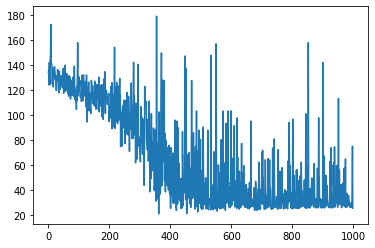

In [54]:
active_bnn_1 = Net(feature_dim=50,q_rank=10).to(opt['device'])
nelbo_1=active_bnn_1.train(initial_train_data_tensor.to(opt['device']),initial_train_label_tensor.to(opt['device']))

In [51]:
likelihood_of_initial_dataset,accuracy=active_bnn_1.likelihood_eva(initial_train_data_tensor.to(opt['device']),initial_train_label_tensor.to(opt['device']))
print(likelihood_of_initial_dataset)
print(accuracy)

tensor([[-26.1191]], device='cuda:0')
1.0


In [55]:
print('nn',active_bnn_1.predictive_distribution_entropy_batch(train_dict[6][1].to(opt['device'])))
print('nn',active_bnn_1.predictive_distribution_entropy_batch(train_dict[7][1].to(opt['device'])))
print('nn',active_bnn_1.predictive_distribution_entropy_batch(train_dict[8][1].to(opt['device'])))
print('nn',active_bnn_1.predictive_distribution_entropy_batch(train_dict[9][1].to(opt['device'])))
print('ni',active_bnn_1.predictive_distribution_entropy_batch(train_dict[1][20].to(opt['device'])))
print('ni',active_bnn_1.predictive_distribution_entropy_batch(train_dict[2][20].to(opt['device'])))
print('ni',active_bnn_1.predictive_distribution_entropy_batch(train_dict[3][20].to(opt['device'])))
print('ni',active_bnn_1.predictive_distribution_entropy_batch(train_dict[4][20].to(opt['device'])))
print('i',active_bnn_1.predictive_distribution_entropy_batch(train_dict[1][1].to(opt['device'])))
print('i',active_bnn_1.predictive_distribution_entropy_batch(train_dict[2][1].to(opt['device'])))
print('i',active_bnn_1.predictive_distribution_entropy_batch(train_dict[3][1].to(opt['device'])))
print('i',active_bnn_1.predictive_distribution_entropy_batch(train_dict[4][1].to(opt['device'])))

nn tensor([ 1.2374], device='cuda:0')
nn tensor([ 1.4055], device='cuda:0')
nn tensor([ 1.4343], device='cuda:0')
nn tensor([ 1.4741], device='cuda:0')
ni tensor([ 0.4802], device='cuda:0')
ni tensor([ 0.5638], device='cuda:0')
ni tensor([ 1.0584], device='cuda:0')
ni tensor([ 0.3238], device='cuda:0')
i tensor([ 0.4447], device='cuda:0')
i tensor([ 0.4947], device='cuda:0')
i tensor([ 0.4059], device='cuda:0')
i tensor([ 0.3219], device='cuda:0')


In [56]:


print('nn',active_bnn_1.predictive_distribution_entropy_2(train_dict[6][1].to(opt['device'])))
print('nn',active_bnn_1.predictive_distribution_entropy_2(train_dict[7][1].to(opt['device'])))
print('nn',active_bnn_1.predictive_distribution_entropy_2(train_dict[8][1].to(opt['device'])))
print('nn',active_bnn_1.predictive_distribution_entropy_2(train_dict[9][1].to(opt['device'])))
print('ni',active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20].to(opt['device'])))
print('ni',active_bnn_1.predictive_distribution_entropy_2(train_dict[2][20].to(opt['device'])))
print('ni',active_bnn_1.predictive_distribution_entropy_2(train_dict[3][20].to(opt['device'])))
print('ni',active_bnn_1.predictive_distribution_entropy_2(train_dict[4][20].to(opt['device'])))
print('i',active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1].to(opt['device'])))
print('i',active_bnn_1.predictive_distribution_entropy_2(train_dict[2][1].to(opt['device'])))
print('i',active_bnn_1.predictive_distribution_entropy_2(train_dict[3][1].to(opt['device'])))
print('i',active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1].to(opt['device'])))

TypeError: can only concatenate list (not "torch.Size") to list

In [58]:
print('nn',active_bnn_1.preactivation_entropy(train_dict[6][1].to(opt['device'])))
print('nn',active_bnn_1.preactivation_entropy(train_dict[7][1].to(opt['device'])))
print('nn',active_bnn_1.preactivation_entropy(train_dict[8][1].to(opt['device'])))
print('nn',active_bnn_1.preactivation_entropy(train_dict[9][1].to(opt['device'])))
print('ni',active_bnn_1.preactivation_entropy(train_dict[1][20].to(opt['device'])))
print('ni',active_bnn_1.preactivation_entropy(train_dict[2][20].to(opt['device'])))
print('ni',active_bnn_1.preactivation_entropy(train_dict[3][20].to(opt['device'])))
print('ni',active_bnn_1.preactivation_entropy(train_dict[4][20].to(opt['device'])))
print('i',active_bnn_1.preactivation_entropy(train_dict[1][1].to(opt['device'])))
print('i',active_bnn_1.preactivation_entropy(train_dict[2][1].to(opt['device'])))
print('i',active_bnn_1.preactivation_entropy(train_dict[3][1].to(opt['device'])))
print('i',active_bnn_1.preactivation_entropy(train_dict[4][1].to(opt['device'])))

RuntimeError: Expected object of type torch.cuda.FloatTensor but found type torch.FloatTensor for argument #2 'vec'

In [59]:
print('nn',active_bnn_1.preactivation_entropy_batch(train_dict[6][1].to(opt['device'])))
print('nn',active_bnn_1.preactivation_entropy_batch(train_dict[7][1].to(opt['device'])))
print('nn',active_bnn_1.preactivation_entropy_batch(train_dict[8][1].to(opt['device'])))
print('nn',active_bnn_1.preactivation_entropy_batch(train_dict[9][1].to(opt['device'])))
print('ni',active_bnn_1.preactivation_entropy_batch(train_dict[1][20].to(opt['device'])))
print('ni',active_bnn_1.preactivation_entropy_batch(train_dict[2][20].to(opt['device'])))
print('ni',active_bnn_1.preactivation_entropy_batch(train_dict[3][20].to(opt['device'])))
print('ni',active_bnn_1.preactivation_entropy_batch(train_dict[4][20].to(opt['device'])))
print('i',active_bnn_1.preactivation_entropy_batch(train_dict[1][1].to(opt['device'])))
print('i',active_bnn_1.preactivation_entropy_batch(train_dict[2][1].to(opt['device'])))
print('i',active_bnn_1.preactivation_entropy_batch(train_dict[3][1].to(opt['device'])))
print('i',active_bnn_1.preactivation_entropy_batch(train_dict[4][1].to(opt['device'])))

nn tensor([ 6.3728])
nn tensor([ 9.7771])
nn tensor([ 9.8061])
nn tensor([ 15.2902])
ni tensor([ 26.8910])
ni tensor([ 24.0951])
ni tensor([ 18.9253])
ni tensor([ 28.4998])
i tensor([ 25.6625])
i tensor([ 23.3338])
i tensor([ 23.5587])
i tensor([ 25.7810])


In [ ]:
plt.imshow(train_dict[6][1].reshape(28,28))

In [ ]:
# active_bnn_1 = Net(feature_dim=200,q_rank=10).to(opt['device'])
for i in range(0,1):
    x_new=train_dict[6][1].view(-1,1,28,28).to(opt['device'])
    label_new=torch.tensor([6]).to(opt['device'])
    active_bnn_1.online_train(x_new,label_new,sample_num=10,iteration=1000)
#     active_bnn_1.online_train(initial_train_data_tensor.to(opt['device']),initial_train_label_tensor.to(opt['device']),sample_num=10,iteration=1000)
    print('entropy',active_bnn_1.predictive_distribution_entropy_batch(train_dict[6][1].to(opt['device'])))
    likelihood_of_initial_dataset,accuracy=active_bnn_1.likelihood_eva(initial_train_data_tensor.to(opt['device']),initial_train_label_tensor.to(opt['device']))
    print('lieklihood',likelihood_of_initial_dataset)
    print('accuracy',accuracy)

In [ ]:
print('nn',active_bnn_1.predictive_distribution_entropy_batch(train_dict[6][1].to(opt['device'])))
print('nn',active_bnn_1.predictive_distribution_entropy_batch(train_dict[7][1].to(opt['device'])))
print('nn',active_bnn_1.predictive_distribution_entropy_batch(train_dict[8][1].to(opt['device'])))
print('nn',active_bnn_1.predictive_distribution_entropy_batch(train_dict[9][1].to(opt['device'])))
print('ni',active_bnn_1.predictive_distribution_entropy_batch(train_dict[1][20].to(opt['device'])))
print('ni',active_bnn_1.predictive_distribution_entropy_batch(train_dict[2][20].to(opt['device'])))
print('ni',active_bnn_1.predictive_distribution_entropy_batch(train_dict[3][20].to(opt['device'])))
print('ni',active_bnn_1.predictive_distribution_entropy_batch(train_dict[4][20].to(opt['device'])))
print('i',active_bnn_1.predictive_distribution_entropy_batch(train_dict[1][1].to(opt['device'])))
print('i',active_bnn_1.predictive_distribution_entropy_batch(train_dict[2][1].to(opt['device'])))
print('i',active_bnn_1.predictive_distribution_entropy_batch(train_dict[3][1].to(opt['device'])))
print('i',active_bnn_1.predictive_distribution_entropy_batch(train_dict[4][1].to(opt['device'])))

In [ ]:
# active_bnn_1 = Net(feature_dim=200,q_rank=100)
for i in range(0,1):
    x_new=train_dict[6][1].view(-1,1,28,28).to(opt['device'])
    label_new=torch.tensor([1]).to(opt['device'])
    active_bnn_1.online_train(x_new,label_new,sample_num=30,iteration=500)
    print('entropy',active_bnn_1.predictive_distribution_entropy_batch(train_dict[7][1].to(opt['device'])))
    likelihood_of_initial_dataset,accuracy=active_bnn_1.likelihood_eva(initial_train_data_tensor.to(opt['device']),initial_train_label_tensor.to(opt['device']))
    print('lieklihood',likelihood_of_initial_dataset)
    print('accuracy',accuracy)

In [ ]:
print('nn',active_bnn_1.predictive_distribution_entropy_batch(train_dict[6][1].to(opt['device'])))
print('nn',active_bnn_1.predictive_distribution_entropy_batch(train_dict[7][1].to(opt['device'])))
print('nn',active_bnn_1.predictive_distribution_entropy_batch(train_dict[8][1].to(opt['device'])))
print('nn',active_bnn_1.predictive_distribution_entropy_batch(train_dict[9][1].to(opt['device'])))
print('ni',active_bnn_1.predictive_distribution_entropy_batch(train_dict[1][20].to(opt['device'])))
print('ni',active_bnn_1.predictive_distribution_entropy_batch(train_dict[2][20].to(opt['device'])))
print('ni',active_bnn_1.predictive_distribution_entropy_batch(train_dict[3][20].to(opt['device'])))
print('ni',active_bnn_1.predictive_distribution_entropy_batch(train_dict[4][20].to(opt['device'])))
print('i',active_bnn_1.predictive_distribution_entropy_batch(train_dict[1][1].to(opt['device'])))
print('i',active_bnn_1.predictive_distribution_entropy_batch(train_dict[2][1].to(opt['device'])))
print('i',active_bnn_1.predictive_distribution_entropy_batch(train_dict[3][1].to(opt['device'])))
print('i',active_bnn_1.predictive_distribution_entropy_batch(train_dict[4][1].to(opt['device'])))

In [ ]:
for i in range(0,10):
    x_new=train_dict[8][21].view(-1,1,28,28)
    label_new=torch.tensor([8])
    active_bnn_1.online_train(x_new,label_new)
    print('entropy',active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
    likelihood_of_initial_dataset,accuracy=active_bnn_1.likelihood_eva(initial_train_data_tensor,initial_train_label_tensor)
    print('lieklihood',likelihood_of_initial_dataset)
    print('accuracy',accuracy)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[4][16].view(-1,1,28,28)
label_new=torch.tensor([4])
active_bnn_1.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
active_bnn_1 = Net(feature_dim=50,q_rank=100)
nelbo_1=active_bnn_1.pre_train(initial_train_data_tensor,initial_train_label_tensor)

In [ ]:
x_new=train_dict[4][16].view(-1,1,28,28)
label_new=torch.tensor([4])

active_bnn_1.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_1.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[1][20].view(-1,1,28,28)
label_new=torch.tensor([1])

active_bnn_1.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_1.online_train(x_new,label_new)

In [ ]:
x_new=train_dict[4][16].view(-1,1,28,28)
label_new=torch.tensor([4])

active_bnn_1.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_1.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_2.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][22].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_2.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
active_bnn_2 = Net(q_rank=2)
nelbo_2=active_bnn_2.pre_train(initial_train_data_tensor,initial_train_label_tensor)

In [ ]:
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
active_bnn_3 = Net(q_rank=3)
nelbo_3=active_bnn_3.pre_train(initial_train_data_tensor,initial_train_label_tensor)

In [ ]:
active_bnn_10 = Net(q_rank=10)
nelbo_10=active_bnn_10.pre_train(initial_train_data_tensor,initial_train_label_tensor)

In [ ]:
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_10.online_train(x_new,label_new)

In [ ]:
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][21].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_10.online_train(x_new,label_new)

In [ ]:
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
active_bnn_50 = Net(q_rank=50)
nelbo_50=active_bnn_50.pre_train(initial_train_data_tensor,initial_train_label_tensor)

In [ ]:
plt.plot(nelbo_50,label='50')
plt.plot(nelbo_10,label='10')
plt.plot(nelbo_3,label='3')
plt.plot(nelbo_2,label='2')
plt.plot(nelbo_1,label='1')

plt.legend()
plt.show()

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
cccccccccccccccccccc

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_1.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_1.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][21].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_1.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
for i in range(0,30):
    print(i)
    print(active_bnn.predictive_distribution_entropy(train_dict[1][i]))
    print(active_bnn.predictive_distribution_entropy(train_dict[8][i]))

In [ ]:
for i in range(0,30):
    x_new=train_dict[8][i].view(-1,1,28,28)
    label_new=torch.tensor([8])

    active_bnn.online_train(x_new,label_new)

In [ ]:
for i in range(0,30):
    print(i)
    print(active_bnn.predictive_distribution_entropy(train_dict[1][i]))
    print(active_bnn.predictive_distribution_entropy(train_dict[8][i]))